In [1]:
#import libraries below
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt                                           
import seaborn as sns                                                    
import networkx as nx

from collections import Counter                                                 # counter for key-value pairs in an object

import re, string, unicodedata                                                  # import text preprocessing libraries
import contractions                                                             # import contractions library
from bs4 import BeautifulSoup                                                   # import BeautifulSoup

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator                 # import wordcloud of a corpus, stopwords
import nltk                                                                     # import nltk library
from nltk.corpus import stopwords                                               # import nltk stopwords
from nltk.tokenize import word_tokenize, sent_tokenize                          # import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer                                 # import Lemmatizer
from nltk.stem.porter import PorterStemmer                                      # import Stemmer

from sklearn.feature_extraction.text import CountVectorizer                     # import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer                     # import TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier                             # import Random Forest Classifier
from sklearn.metrics import classification_report                               # import classification report
from sklearn.model_selection import cross_val_score 
from sklearn.metrics.pairwise import cosine_similarity
# download stopwords
nltk.download('punkt')
nltk.download('wordnet')
import copy 

[nltk_data] Downloading package punkt to /Users/deepwalke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deepwalke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# IMPORT DATA

In [2]:
# load the dataset of tweets
path1 = "/Users/deepwalke/Documents/deep/8th sem/Graph Theory/Assignment4/Tweets.csv"
tweets = pd.read_csv(path1)
# create copy of dataset
df = tweets.copy()

In [3]:
# print the shape of the dataset
df.shape

(14640, 15)

In [4]:
# show first five rows of data
df.head(n=5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# show summary of dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:

# convert all columns with dtype object into category to save memory
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [7]:
# convert tweet_id into a category to save memory
df['tweet_id'] = df['tweet_id'].astype('category')

In [8]:
# convert tweet_created into a datetime to allow for time series analysis
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df['tweet_created'] = df['tweet_created'].astype('datetime64[ns]')

/var/folders/d0/gvsk9t6s60l_qhvy15qt8k2c0000gn/T/ipykernel_5354/1342141947.py:3: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df['tweet_created'] = df['tweet_created'].astype('datetime64[ns]')


In [9]:
# show summary of dataset after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

In [10]:
df=df.head(1000)

In [11]:
column_list = df.columns.to_list()


In [12]:
# identify columns used for model building
columns = ['text','airline_sentiment']

In [13]:
# identify columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [14]:
# drop all other columns except “text” and “airline_sentiment”
df_model = df.drop(columns = drop_columns)

In [15]:
# confirm new shape of the dataset
df_model.shape

(1000, 2)

In [16]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (non-turncated text column.)
#print head of new dataset
df_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


# DATA CLEANING

In [17]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
df_model['text'] = df_model['text'].apply(lambda x: clean_text(x))
df_model.head()

/Users/deepwalke/Library/Python/3.9/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


# TOKENIZATION

In [18]:
df_model['text'] = df_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
df_model.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepwalke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_model['text'] = df_model.apply(lambda row: normalize(row['text']), axis=1)
df_model.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


In [21]:
print(df_model['text'])

0                                                                                                     say
1                                                                   plus add commercials experience tacky
2                                                                  today must mean need take another trip
3                             really aggressive blast obnoxious entertainment guests face little recourse
4                                                                                    really big bad thing
                                                      ...                                                
995                                          time finally get dallas could drive less frustration cheaper
996                                   try get final destination need compensation hrs personal time waste
997    guy really customer service cluecould spend effort clear bin rollerboards instead art project mine
998                                           

In [22]:
TfVector = TfidfVectorizer(stop_words='english', token_pattern='[a-zA-Z][a-zA-Z0-9]{2,}', max_features=1000000)
vectors = TfVector.fit_transform(df_model['text']).toarray()
feature_names = TfVector.get_feature_names_out()


In [23]:
df = pd.DataFrame(vectors, columns=feature_names)
df

,abbreve,abc,ability,able,abq,absolute,absolutely,absurd,absurdly,abundance,...,youk,yous,yrs,yulord,yummy,yvr,zambia,zccu,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# find non zero values in a matrix
df_model['text'].apply(lambda x: np.count_nonzero(x))

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: text, Length: 1000, dtype: int64

# Q.1 Compute the complete graph G= (V, E) of the project dataset.

In [25]:
def makeGraph(vectors):
    G = nx.Graph()
    for i in range(len(vectors)):
        for j in range(i+1,len(vectors)):
            if i != j:
                val  = 1 - cosine_similarity([vectors[i]], [vectors[j]])[0][0]
                if val < 1:
                    G.add_edge(i, j, weight = val)
    return G

G = makeGraph(vectors)


# Q.2. Construct MST neighborhood graph of 3-round i.e. G’ =(V, E’).

In [26]:
# Construct MST neighborhood graph of 3-round
T=3
G_copy=copy.deepcopy(G)
MST = nx.minimum_spanning_tree(G)
MST_3 = MST
for i in range(T-1):
    for j in MST.edges(data=True):
        G_copy.remove_edge(j[0],j[1])
    MST = nx.minimum_spanning_tree(G_copy)
    MST_3 = nx.compose(MST_3,MST)

# open('Data/MST1000.txt', 'w')
# nx.write_edgelist(MST, "Data/MST1000.txt", data=True)
# print(MST.edges(data=True))

In [27]:
open('Data/MST_3_1000.txt', 'w')
nx.write_edgelist(MST, "Data/MST_3_1000.txt", data=['weight'])
print(MST.edges(data=True))

[(0, 526, {'weight': 0.6915733661519486}), (0, 987, {'weight': 0.7137354243949419}), (0, 529, {'weight': 0.7301714190782479}), (0, 929, {'weight': 0.7396125274913044}), (0, 181, {'weight': 0.7516191945076962}), (0, 596, {'weight': 0.7638380899659114}), (0, 779, {'weight': 0.8011098151389613}), (26, 228, {'weight': 0.7981479130259219}), (131, 624, {'weight': 0.7845863195241958}), (181, 520, {'weight': 0.7506919047322547}), (181, 341, {'weight': 0.7536336975500227}), (302, 630, {'weight': 0.8778153038384381}), (315, 812, {'weight': 0.8153245757136856}), (386, 180, {'weight': 0.842264795420936}), (407, 219, {'weight': 0.7666532861234315}), (407, 651, {'weight': 0.7854759481584124}), (407, 561, {'weight': 0.7953243779231755}), (464, 799, {'weight': 0.8187041480107992}), (464, 337, {'weight': 0.8386825903071962}), (481, 966, {'weight': 0.6989685366288538}), (481, 197, {'weight': 0.7004066654599617}), (481, 397, {'weight': 0.7823634750782466}), (481, 484, {'weight': 0.7879821493399872}), (49

# Q3: Let A’ be the adjacency matrix of G’. Compute the adjacency matrix A’.


In [28]:
G_Matrix=nx.adjacency_matrix(MST_3).todense()

# Q4: Find the degree matrix D of G’, where each D(i,j)=0, i≠j and D(i,i)=∑j∈N(i)A’(i,j).


In [29]:
Deg_Matrix = np.zeros((len(G_Matrix),len(G_Matrix)))
for i in range(len(G_Matrix)):
    Deg_Matrix[i][i] = np.sum(G_Matrix[i])

print(Deg_Matrix)

[[16.61346975  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          3.08126467  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          3.72694069 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.86317313  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.0992479
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   2.59119709]]


# Q.5 Compute the Laplacian Matrix L= D-A’.

In [30]:
L_Matrix = Deg_Matrix - G_Matrix
print(L_Matrix)

[[16.61346975 -0.76516955 -0.6918843  ...  0.          0.
   0.        ]
 [-0.76516955  3.08126467  0.         ...  0.          0.
   0.        ]
 [-0.6918843   0.          3.72694069 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  4.86317313  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.0992479
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   2.59119709]]


# Q6: Compute first k eigenvectors v1, v2, v3, vk of L, where k is the number of clusters in your dataset.


In [31]:
eigenvalues, eigenvectors = np.linalg.eig(L_Matrix)
numClusters = 3

idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

topKVectors = eigenvectors[:, :numClusters]

# Q7: Form a n*k matrix U, where each eigenvector vi; 1≤i≤k is stacked as a column in U. Treat each row ui 1≤i≤n of U as a data point


In [32]:
U_Matrix=np.zeros((len(G_Matrix),numClusters))
for i in range(len(G_Matrix)):
    U_Matrix[i] = topKVectors[i]

In [33]:
print(U_Matrix.shape)

(984, 3)


# Q8: Apply k-means and MST based clustering algorithm to partition the points ui=1,2,3,....n into k clusters.

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(U_Matrix)

from sklearn.metrics import silhouette_score
print(silhouette_score(U_Matrix, kmeans.labels_, metric='euclidean'))

0.9891455951665729


/Users/deepwalke/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
# MST based clustering algorithm
G_new = makeGraph(U_Matrix)
MST_new  = nx.minimum_spanning_tree(G_new)
nx.write_edgelist(MST_new, "Data/MST2_3_1000.txt", data=['weight'])

# remmove k largest edges
k = numClusters-1
G_new_copy = copy.deepcopy(G_new)
for _ in range(k):
    maxEdge = max(MST_new.edges(data=True), key=lambda x: x[2]['weight'])
    MST_new.remove_edge(maxEdge[0], maxEdge[1])

In [36]:
subgraphs = [MST_new.subgraph(c).copy() for c in nx.connected_components(MST_new)]
labels = [0] * len(MST_new.nodes())
for i in range(len(MST_new.nodes())):
    for j in range(len(subgraphs)):
        if i in subgraphs[j].nodes():
            labels[i] = j

# shilouette score
G_New_Matrix = nx.adjacency_matrix(G_new).todense()
from sklearn.metrics import silhouette_score
print(silhouette_score(G_New_Matrix, labels, metric='euclidean'))

-0.06566420224954977


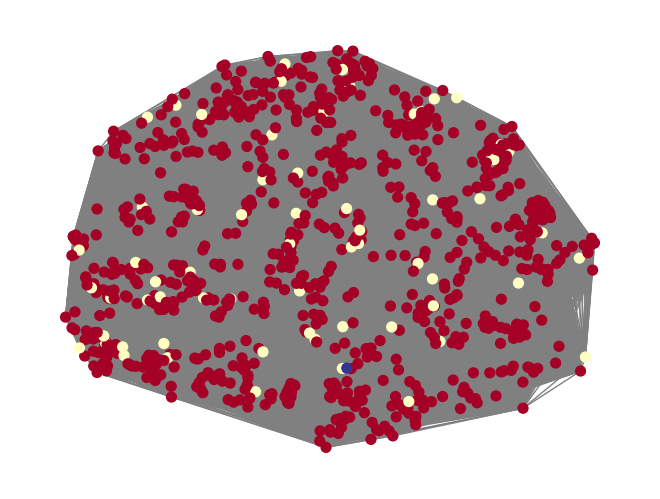

In [41]:
# plot the graph
pos = nx.spring_layout(G_new)
nx.draw(G_new, pos, node_color=labels, node_size=50, cmap=plt.cm.RdYlBu, edge_color='grey')
plt.show()